# SSD512 Inference Tutorial

This is a brief tutorial that shows how to use a trained SSD512 for inference on the Pascal VOC datasets. It is the same as the SSD300 inference tutorial but with all parameters preset for SSD512 for Pascal VOC. If you'd like more detailed explanations on how to use the model generally, please refer to [`ssd300_training.ipynb`](https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd300_training.ipynb)

In [19]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from scipy.misc import imread
import numpy as np
from matplotlib import pyplot as plt

from keras_ssd512 import ssd_512
from keras_ssd_loss import SSDLoss
from keras_layer_AnchorBoxes import AnchorBoxes
from keras_layer_L2Normalization import L2Normalization
from ssd_box_encode_decode_utils import decode_y, decode_y2
from ssd_batch_generator import BatchGenerator

%matplotlib inline

In [20]:
# Set the image size.
img_height = 512
img_width = 512

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [21]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_512(image_size=(img_height, img_width, 3),
                n_classes=20,
                l2_regularization=0.0005,
                scales=[0.07, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05], # The scales for MS COCO are [0.04, 0.1, 0.26, 0.42, 0.58, 0.74, 0.9, 1.06]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
               two_boxes_for_ar1=True,
               steps=[8, 16, 32, 64, 128, 256, 512],
               offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
               limit_boxes=False,
               variances=[0.1, 0.1, 0.2, 0.2],
               coords='centroids',
               normalize_coords=True,
               subtract_mean=[123, 117, 104],
               swap_channels=True)

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.

weights_path = 'path/to/trained/weights/VGG_VOC0712_SSD_512x512_iter_120000.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-04)

ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

Or

### 1.2. Load a trained model

In [ ]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'path/to/trained/model.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'compute_loss': ssd_loss.compute_loss})

## 2. Load some images

Load some images for which you'd like the model to make predictions.

In [4]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
img_path = 'examples/fish_bike.jpg'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img)
input_images.append(img)
input_images = np.array(input_images)

## 3. Make predictions and decode them

In [5]:
y_pred = model.predict(input_images)

In [6]:
y_pred_decoded = decode_y(y_pred,
                          confidence_thresh=0.5,
                          iou_threshold=0.45,
                          top_k=200,
                          input_coords='centroids',
                          normalize_coords=True,
                          img_height=img_height,
                          img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('    class    conf  xmin    ymin    xmax    ymax')
print(y_pred_decoded[0])

Predicted boxes:

    class    conf  xmin    ymin    xmax    ymax
[[   2.      0.97   23.71  104.68  470.06  490.18]
 [  15.      1.    216.46   10.54  361.56  296.44]]


## 4. Visualize the predictions

We just resized the input image above and made predictions on the distorted image. We'd like to visualize the predictions on the image in its original size though, so below we'll transform the coordinates of the predicted boxes accordingly.

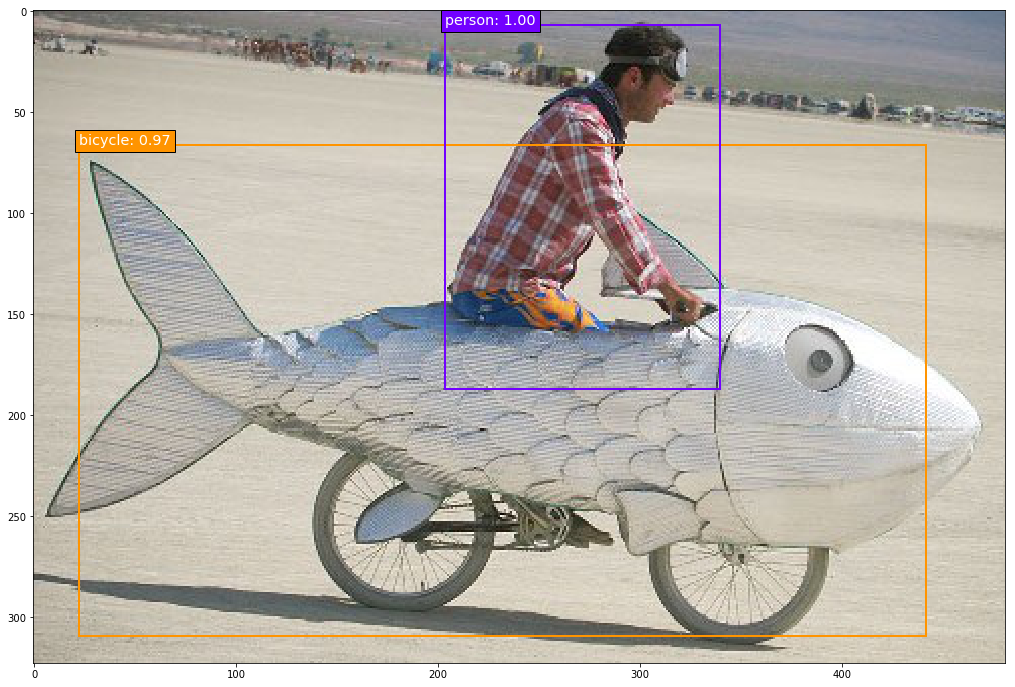

In [7]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_decoded[0]:
    # Transform the predicted bounding boxes for the 512x512 image to the original image dimensions.
    xmin = box[-4] * orig_images[0].shape[1] / img_width
    ymin = box[-3] * orig_images[0].shape[0] / img_height
    xmax = box[-2] * orig_images[0].shape[1] / img_width
    ymax = box[-1] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

## 5. Make predictions on Pascal VOC 2007 Test

Let's use the batch generator to make predictions on the Pascal VOC 2007 test dataset and visualize the predicted boxes alongside the ground truth boxes for comparison.

In [45]:
# Create a `BatchGenerator` instance and parse the Pascal VOC labels.

dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'ymin', 'xmax', 'ymax'])

# TODO: Set the paths to the datasets here.

VOC_2007_test_images_dir         = '../../datasets/VOCdevkit/VOC2007_Test/JPEGImages/'
VOC_2007_test_annotations_dir    = '../../datasets/VOCdevkit/VOC2007_Test/Annotations/'
VOC_2007_test_image_set_filename = '../../datasets/VOCdevkit/VOC2007_Test/ImageSets/Main/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

dataset.parse_xml(images_dirs=[VOC_2007_test_images_dir],
                  image_set_filenames=[VOC_2007_test_image_set_filename],
                  annotations_dirs=[VOC_2007_test_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=True,
                  ret=False)

generator = dataset.generate(batch_size=1,
                             shuffle=True,
                             train=False,
                             returns={'processed_images',
                                      'filenames',
                                      'inverse_transform',
                                      'original_images',
                                      'original_labels'},
                             max_crop_and_resize=False,
                             random_pad_and_resize=False,
                             resize=(img_height,img_width))

In [14]:
# Generate a batch and make predictions.

batch_X, batch_filenames, batch_inverse_coord_transform, batch_original_images, batch_original_labels = next(generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

Image: ../../datasets/VOCdevkit/VOC2007_Test/JPEGImages/003680.jpg

Ground truth boxes:

[[ 13  58 182 413 465]
 [ 13 447   1 512 197]
 [ 15 392  12 453 169]
 [ 15 359   2 406 195]
 [ 15 318  10 366 167]
 [ 15 300 169 357 438]
 [ 15 352 387 440 512]
 [ 15 252 419 324 512]
 [ 15 172  13 202  73]
 [ 15 131   2 167  62]
 [ 15  81   2 110 193]
 [ 15  96   4 145 193]
 [ 15 136  27 201 193]
 [ 15   2 309  50 512]]


In [15]:
# Predict.

y_pred = model.predict(batch_X)

In [16]:
# Decode the predictions.

y_pred_decoded = decode_y(y_pred,
                          confidence_thresh=0.5,
                          iou_threshold=0.45,
                          top_k=200,
                          input_coords='centroids',
                          normalize_coords=True,
                          img_height=img_height,
                          img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('    class    conf  xmin    ymin    xmax    ymax')
print(y_pred_decoded[i])

Predicted boxes:

    class    conf  xmin    ymin    xmax    ymax
[[  13.      1.     55.47  167.99  415.03  476.31]
 [  13.      0.7   439.58    0.11  507.39  187.56]
 [  15.      0.97  318.84    4.92  368.34  187.62]
 [  15.      0.96  357.95    0.61  398.46  190.  ]
 [  15.      0.89  386.82    4.2   433.5   173.37]
 [  15.      0.8    91.84    0.81  144.07  198.17]
 [  15.      0.8   138.98   17.39  197.63  197.01]
 [  15.      0.78  345.51  382.14  399.51  502.61]
 [  15.      0.7   358.52  377.57  464.46  511.61]
 [  15.      0.57  174.49    7.39  199.9    60.06]]


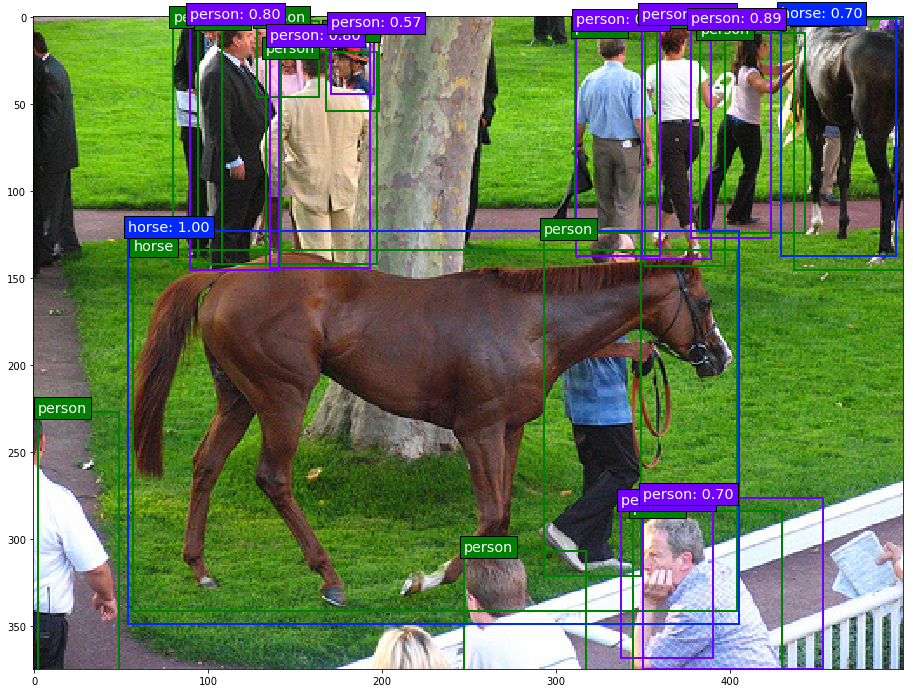

In [17]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for k, box in enumerate(y_pred_decoded[i]):
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = (box[-4] * batch_inverse_coord_transform[i,0,1]) + batch_inverse_coord_transform[i,0,0]
    ymin = (box[-3] * batch_inverse_coord_transform[i,1,1]) + batch_inverse_coord_transform[i,1,0]
    xmax = (box[-2] * batch_inverse_coord_transform[i,2,1]) + batch_inverse_coord_transform[i,2,0]
    ymax = (box[-1] * batch_inverse_coord_transform[i,3,1]) + batch_inverse_coord_transform[i,3,0]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})